In [1]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import rc_to_nest, operator_map_reaction
from IPython.display import SVG
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [3]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_mech_labeled_reactions.parquet"
)
mm["mech_atoms"] = mm["mech_atoms"].apply(rc_to_nest)
mm["reaction_center"] = mm["reaction_center"].apply(rc_to_nest)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,rule_id
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"(((1, 2, 3, 4),), ((0, 1, 2, 3),))","(((1, 7, 8, 9),), ((),))",glutamate racemase,P56868,5.1.1.3,265
1,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"(((1, 2, 3, 4),), ((0, 1, 2, 3),))","(((1, 7, 8, 9),), ((),))",glutamate racemase,P56868,5.1.1.3,265
2,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"(((5, 7), (0,)), ((0, 1, 2),))","(((5, 6, 7), (0,)), ((),))",beta-lactamase (Class A),P62593,3.5.2.6,865
3,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"(((5, 7), (0,)), ((0, 1, 2),))","(((5, 6, 7), (0,)), ((),))",beta-lactamase (Class A),P62593,3.5.2.6,865
4,6,1,NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,[NH2:17][CH:14]([CH2:12][CH2:9][C:6](=[O:10])[...,[#16:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[...,"(((9, 10), (3, 4, 5, 45, 46, 47)), ((0,), (0,)...","(((9, 10), (3, 4, 5, 47)), ((),))",glutathione-disulfide reductase,P00390,1.8.1.7,389


In [4]:
min_rules = pd.read_csv(
    filepath_or_buffer=Path(cfg.artifacts) / "rules" / "min_rules.tsv",
    sep="\t",
)
min_rules.head()

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [5]:
decarb_rule = min_rules.loc[min_rules['Name'] == 'rule0024', "SMARTS"].iloc[0]

In [6]:
decarb_rule

'[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3]'

In [7]:
mcsa_decarbs = mm.loc[mm['rule'] == decarb_rule]
print(len(mcsa_decarbs))
mcsa_decarbs.head()

29


,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,rule_id
35,49,1,NC(Cc1c[nH]cn1)C(=O)O>>NCCc1c[nH]cn1.O=C=O,[NH2:2][CH:1]([CH2:3][c:4]1[cH:5][nH:7][cH:8][...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((1, 8, 10),), ((0,), (0, 1)))","(((0, 1, 8, 10),), ((),))",histidine decarboxylase,P00862,4.1.1.22,919
36,50,1,O=C(O)c1cc(=O)[nH]c(=O)n1C1OC(COP(=O)(O)O)C(O)...,[O:24]=[C:22]([OH:23])[c:1]1[cH:2][c:4](=[O:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((3, 1, 2),), ((0,), (0, 1)))","(((1, 2, 3),), ((),))",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23,919
37,50,3,O=C(O)c1cc(=O)[nH]c(=O)n1C1OC(COP(=O)(O)O)C(O)...,[O:24]=[C:22]([OH:23])[c:1]1[cH:2][c:4](=[O:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((3, 1, 2),), ((0,), (0, 1)))","(((1, 2, 3, 4),), ((),))",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23,919
38,50,2,O=C(O)c1cc(=O)[nH]c(=O)n1C1OC(COP(=O)(O)O)C(O)...,[O:24]=[C:22]([OH:23])[c:1]1[cH:2][c:4](=[O:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((3, 1, 2),), ((0,), (0, 1)))","(((1, 2, 3, 4, 5, 6),), ((),))",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23,919
57,70,1,CC(C(=O)O)C(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP...,[CH3:2][CH:1]([C:53](=[O:55])[OH:54])[C:3](=[O...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((1, 2, 4),), ((0,), (0, 1)))","(((1, 2, 4, 5, 6),), ((),))",methylmalonyl-CoA decarboxylase,P52045,7.2.4.3,919


Showing example: 49, 1


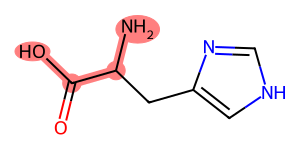

Showing example: 50, 1


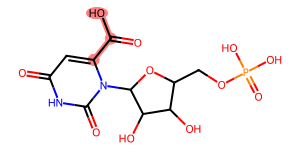

Showing example: 50, 3


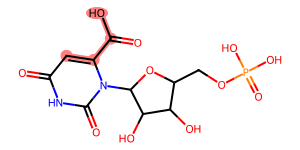

Showing example: 50, 2


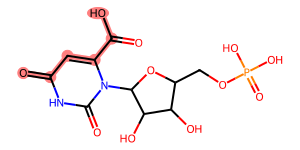

Showing example: 70, 1


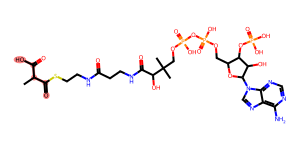

Showing example: 72, 1


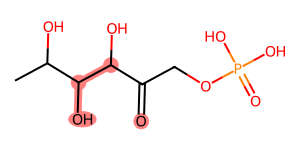

Showing example: 182, 1


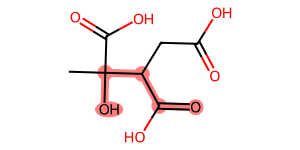

Showing example: 182, 2


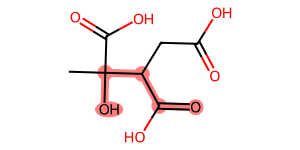

Showing example: 182, 3


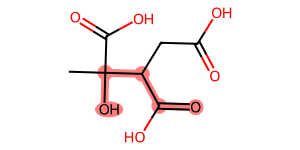

Showing example: 182, 4


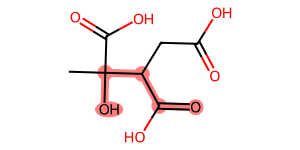

Showing example: 215, 1


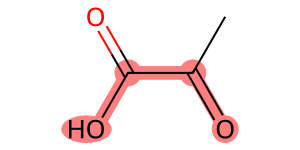

Showing example: 217, 1


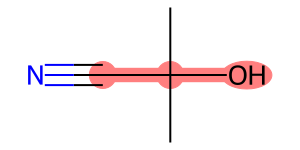

Showing example: 220, 2


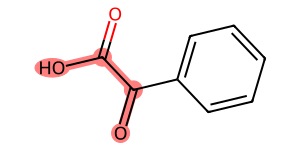

Showing example: 220, 3


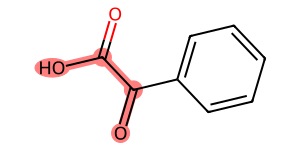

Showing example: 220, 1


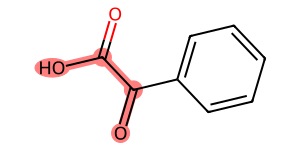

Showing example: 221, 1


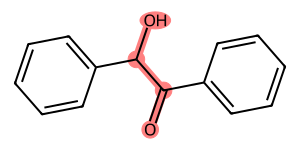

Showing example: 225, 1


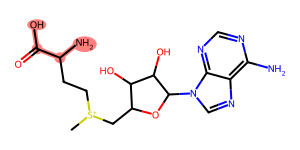

Showing example: 236, 1


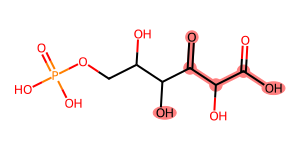

Showing example: 236, 2


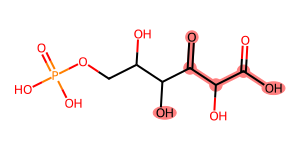

Showing example: 272, 1


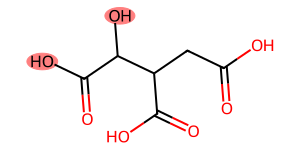

Showing example: 409, 2


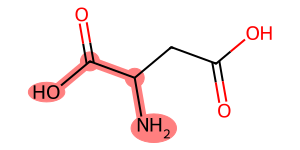

Showing example: 639, 1


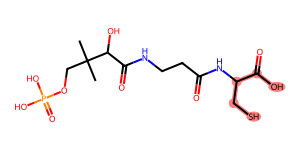

Showing example: 645, 1


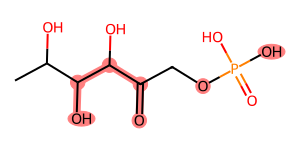

Showing example: 652, 1


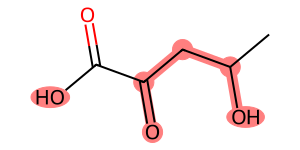

Showing example: 664, 1


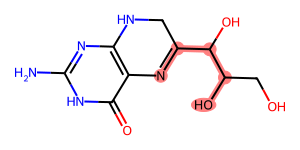

Showing example: 675, 1


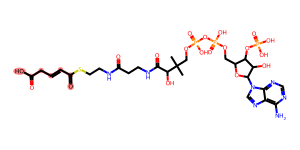

Showing example: 846, 1


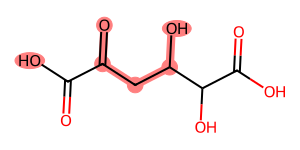

Showing example: 941, 1


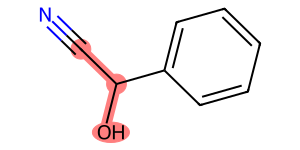

Showing example: 992, 1


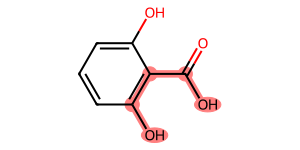

In [8]:
for i, row in mcsa_decarbs.iterrows():
    smarts = row["smarts"]
    reaction_center = row["reaction_center"]
    mech_atoms = row["mech_atoms"][0][0]
    rct = Chem.MolFromSmiles(smarts.split('>>')[0])
    print(f"Showing example: {row["entry_id"]}, {row["mechanism_id"]}")
    img = draw_molecule(rct, size=(300, 150), highlight_atoms=mech_atoms)
    display(SVG(img))

    with open(Path(cfg.artifacts) / "imgs" / "mcsa_decarbs" / f"{row['entry_id']}_{row['mechanism_id']}.svg", "w") as f:
        f.write(img)

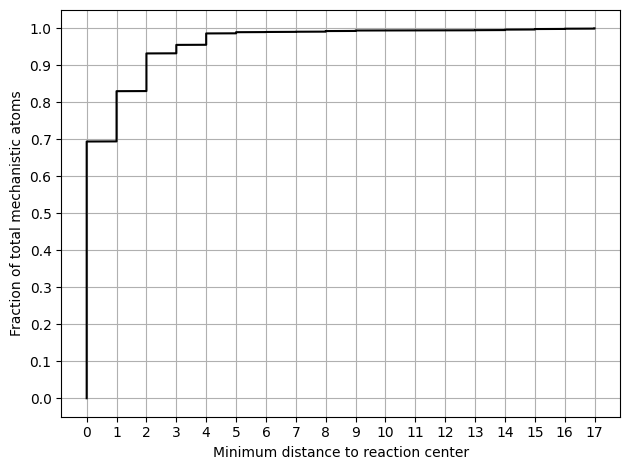

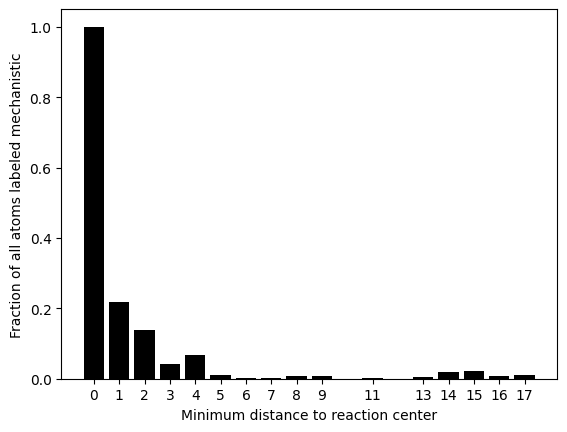

In [9]:
tmp = []
tot_by_radius = defaultdict(int)
mech_by_radius = defaultdict(int)
for i, row in mm.iterrows():
    smarts = row["smarts"]
    lhs_mols = [Chem.MolFromSmiles(elt) for elt in smarts.split('>>')[0].split('.')]
    lrc = row["reaction_center"][0]
    mech_atoms = row["mech_atoms"][0]
    for mol, rc, mech in zip(lhs_mols, lrc, mech_atoms):
        for atom in mol.GetAtoms():
            aidx = atom.GetIdx()
            min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)

            tot_by_radius[min_dist] += 1

            if aidx in mech or min_dist == 0:
                mech_by_radius[min_dist] += 1
                tmp.append((min_dist, row["entry_id"], row["mechanism_id"]))

min_dists_to_rc = sorted([x[0] for x in tmp])
df = pd.DataFrame(tmp, columns=["min_dist_to_rc", "entry_id", "mechanism_id"]).sort_values(by="min_dist_to_rc", ascending=False)
ycdf = np.arange(len(min_dists_to_rc)) / len(min_dists_to_rc)

frac_by_radius = {k: mech_by_radius[k] / tot_by_radius[k] for k in mech_by_radius.keys()}

fig, ax = plt.subplots()
ax.plot(min_dists_to_rc, ycdf, color='black')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, max(min_dists_to_rc) + 1, 1))
ax.set_xlabel("Minimum distance to reaction center")
ax.set_ylabel("Fraction of total mechanistic atoms")
ax.grid()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
x = list(frac_by_radius.keys())
y = list(frac_by_radius.values())
ax.bar(x, y, color='black')
ax.set_xticks(x)
ax.set_xlabel("Minimum distance to reaction center")
ax.set_ylabel("Fraction of all atoms labeled mechanistic")
plt.show()

In [22]:
max_min_dist = df.groupby(["entry_id", "mechanism_id"])["min_dist_to_rc"].max().reset_index()
max_min_dist = max_min_dist.sort_values(by="min_dist_to_rc", ascending=False).reset_index(drop=True)
print(len(max_min_dist))
max_min_dist.head(15)

447


,entry_id,mechanism_id,min_dist_to_rc
0,116,1,17
1,291,1,16
2,33,1,15
3,999,1,11
4,329,2,9
5,557,1,9
6,840,1,9
7,578,1,8
8,385,1,6
9,190,1,6


Showing example: 190, 1


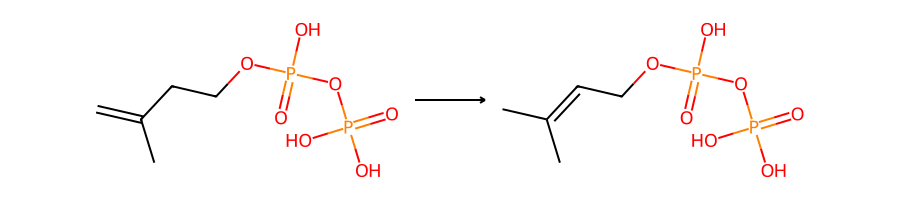

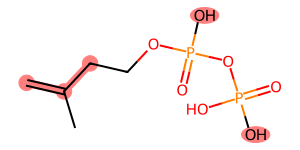

Showing example: 826, 1


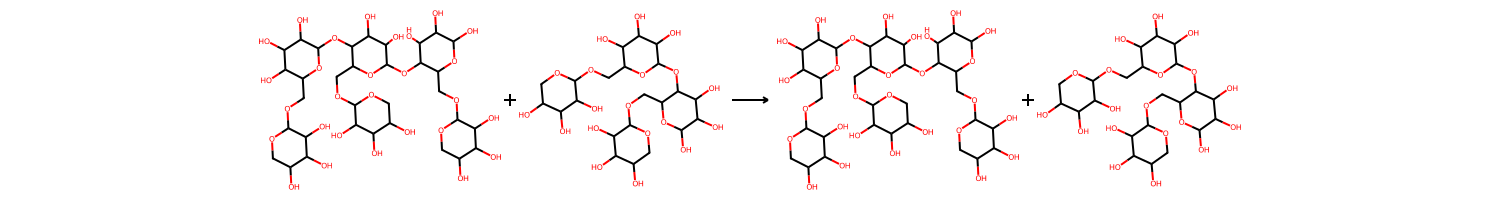

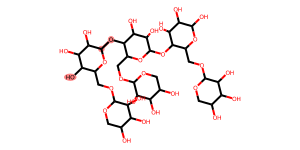

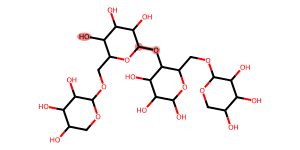

Showing example: 774, 2


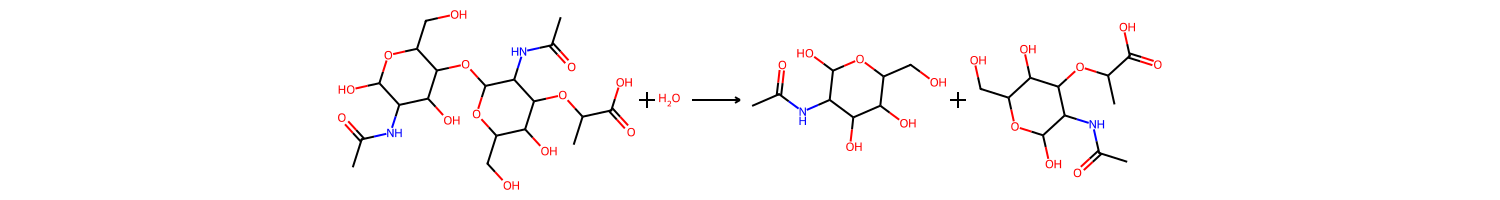

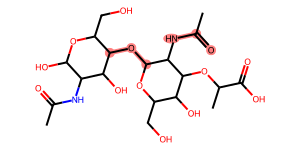

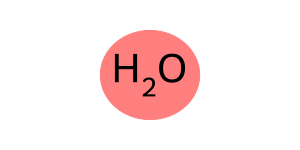

Showing example: 899, 2


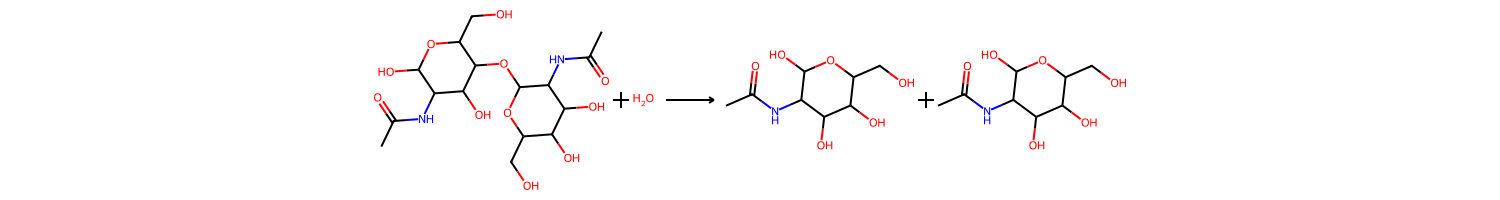

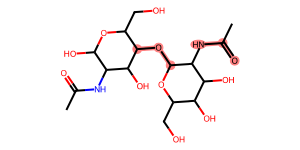

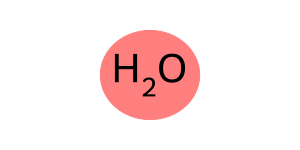

Showing example: 645, 1


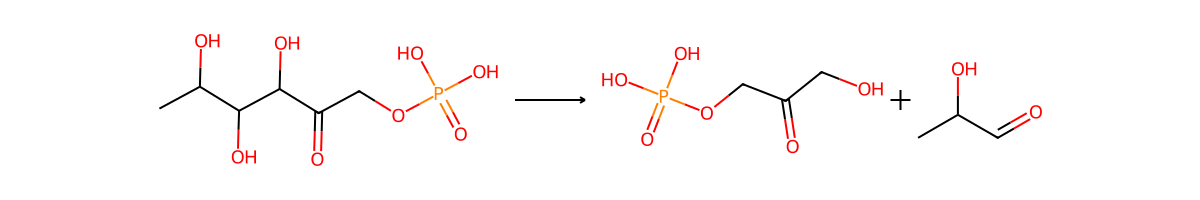

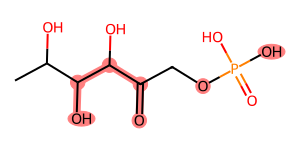

Showing example: 24, 1


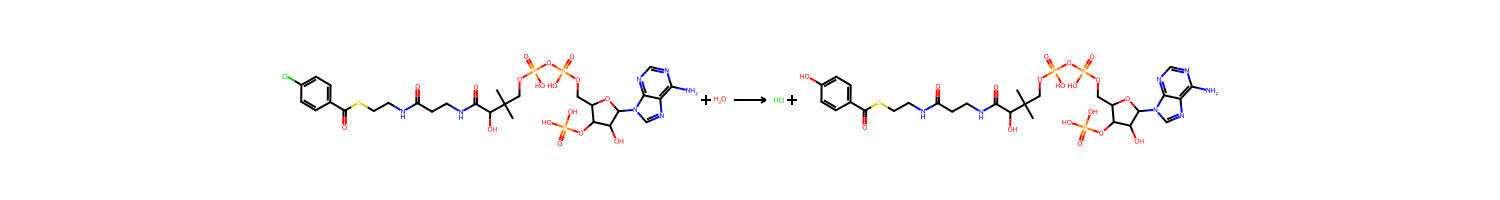

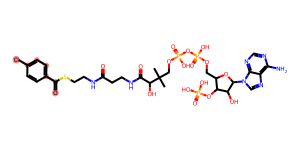

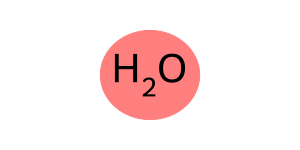

Showing example: 817, 1


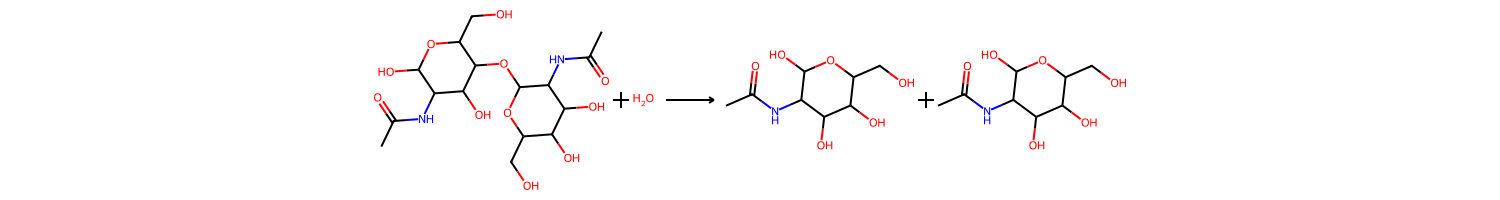

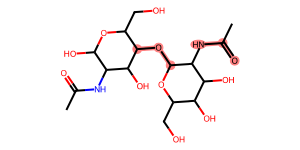

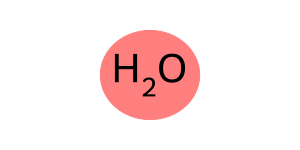

Showing example: 347, 1


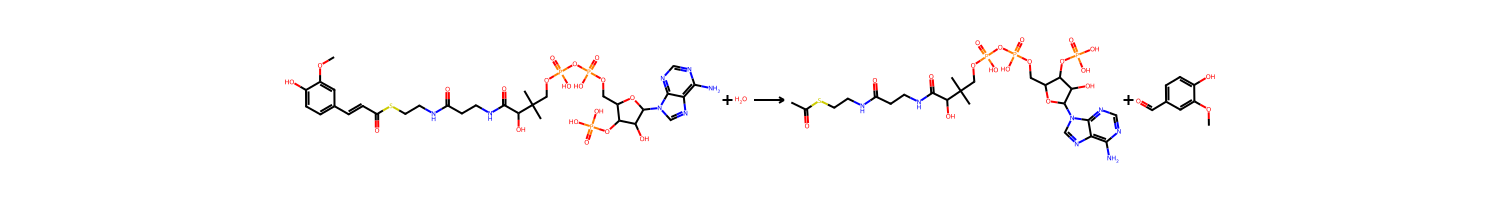

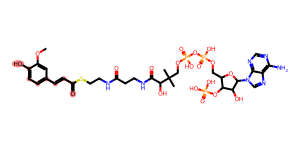

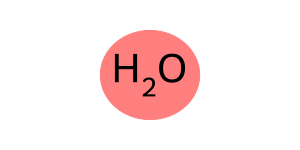

Showing example: 863, 1


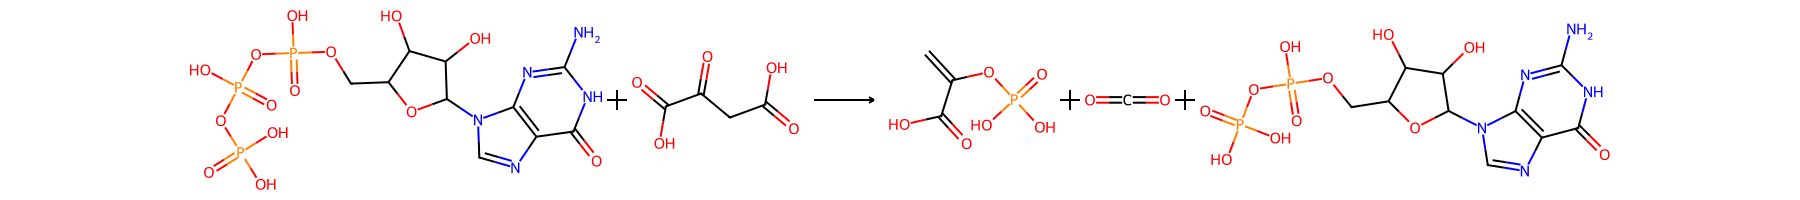

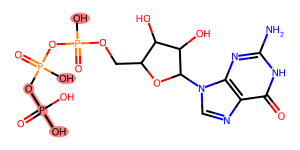

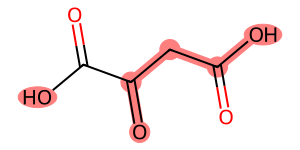

Showing example: 665, 1


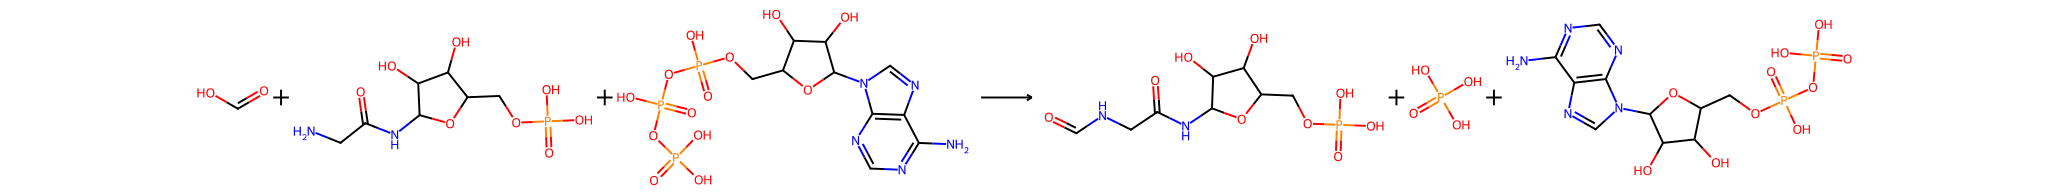

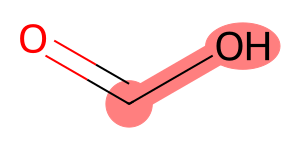

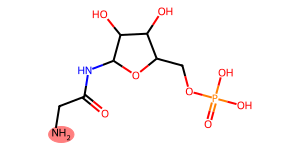

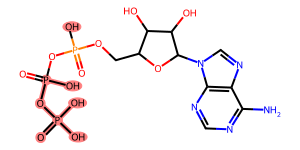

Showing example: 844, 1


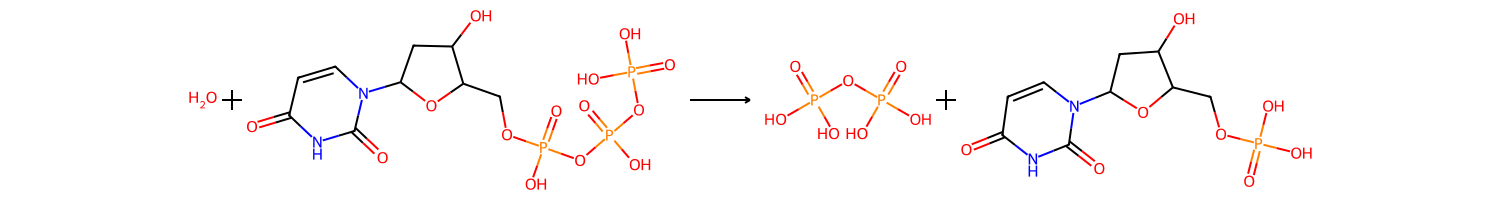

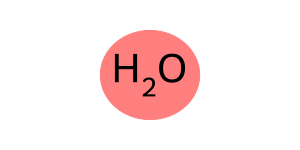

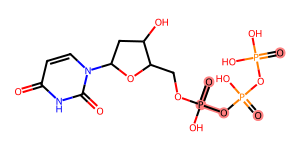

In [27]:
for i, row in max_min_dist.iloc[9:20].iterrows():
    entry_id = row["entry_id"]
    mechanism_id = row["mechanism_id"]
    reaction_row = mm.loc[(mm["entry_id"] == entry_id) & (mm["mechanism_id"] == mechanism_id)].iloc[0]
    smarts = reaction_row["smarts"]
    reaction_center = reaction_row["reaction_center"]
    mech_atoms = reaction_row["mech_atoms"]
    rct = Chem.MolFromSmiles(smarts.split('>>')[0])
    print(f"Showing example: {entry_id}, {mechanism_id}")
    display(SVG(draw_reaction(smarts)))
    for smi, rc, ma in zip(smarts.split(">>")[0].split("."), reaction_center[0], mech_atoms[0]):
        hatoms = list(set(rc) | set(ma))
        display(SVG(draw_molecule(smi, size=(300, 150), highlight_atoms=hatoms)))